# 1. Prepare the environment

In [1]:
import os
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from Label_Bot.label_bot import utils

from sklearn.metrics import accuracy_score as accuracy

from simpletransformers.classification import MultiLabelClassificationModel

## 1.1. Load the fine-tuned model

In [2]:
model_path = 'models/classification/roberta-base'

with open(f'{model_path}/model_args.json') as f:
    model_args = json.load(f)

model = utils.load_model(model_args, task='mlc', from_path=model_path)

##  1.2. Prepare the datasets

The original model is fine-tuned in a big dataset, which is great but has a serious drawback; the lack of enough training examples that have more than one labels. If we retain here the original distribution, this issue is not going to be addressed, so instead we use all the examples that have multiple labels and for each of the rest of the classes we keep as many examples we keep only as many as the number of examples that have multiple labels. 

Although this partially solves the problem, there are a couple of things we need to consider: 
<ul>
    <li> 
        Some combinations are still underrepresented and since the number of examples of these combinations is quite small, if we want to fully solve this issue we have to augment the original dataset either physically or synthetically, with more examples that fall in more than one categories. 
    </li>
    <br>
    <li>
        Ideally, instead of the raw scores we would feed the logits of the fine-tuned model to the head, but due to the fact that these logits aren't returned if we want to get them we have to clone and tweak the code of the used library. 
    </li>
    <br>
    <li>
        Using the additional head can have an extra benefit. If we had used fewer examples during the fine-tuning, the head could boost the results significantly. For example, when I used 20k examples from each class during the fine-tuning phase (instead of 90k), the additional of the head significantly increased the score of almost all of the metrics that are used for evaluation in the <code>stats.ipynb</code> file. 
    </li>
</ul>

In [12]:
bugs_train, questions_train, enhancements_train, comb_train = utils.sample_df(pd.read_pickle('train_90k.pkl'), 
                                                                              n=5000, 
                                                                              to_keep=['title', 
                                                                                       'body', 
                                                                                       'label_bug', 
                                                                                       'label_question', 
                                                                                       'label_enhancement'])

bugs_val, questions_val, enhancements_val, comb_val = utils.sample_df(pd.read_pickle('val_90k.pkl'), 
                                                                      n=550, 
                                                                      to_keep=['title', 
                                                                               'body', 
                                                                               'label_bug', 
                                                                               'label_question', 
                                                                               'label_enhancement'])

In [13]:
train_df = pd.concat((bugs_train, 
                      questions_train, 
                      enhancements_train, 
                      comb_train), axis=0, ignore_index=True)

val_df = pd.concat((bugs_val, 
                    questions_val, 
                    enhancements_val, 
                    comb_val), axis=0, ignore_index=True)

### 1.2.1. Calculate the scores and save them for future use

In [ ]:
scores = model.predict(val_df.title)[1]
np.save(f'val_scores_titles', scores)

scores = model.predict(val_df.body)[1]
np.save(f'val_scores_bodies', scores)

scores = model.predict(val_df.title + ' ' + val_df.body)[1]
np.save(f'val_scores_combined', scores)

np.save(f'val_scores_labels', utils.make_st_compatible(val_df).labels)


scores = model.predict(train_df.title)[1]
np.save(f'train_scores_titles', scores)

scores = model.predict(train_df.body)[1]
np.save(f'train_scores_bodies', scores)

scores = model.predict(train_df.title + ' ' + train_df.body)[1]
np.save(f'train_scores_combined', scores)

np.save(f'train_scores_labels', utils.make_st_compatible(train_df).labels)

In [15]:
train_scores_titles = np.load('train_scores_titles.npy')
train_scores_bodies = np.load('train_scores_bodies.npy')
train_scores_combined = np.load('train_scores_combined.npy')

train_labels = np.load('train_scores_labels.npy', allow_pickle=True)
train_labels = list(map(list, train_labels))


val_scores_titles = np.load('val_scores_titles.npy')
val_scores_bodies = np.load('val_scores_bodies.npy')
val_scores_combined = np.load('val_scores_combined.npy')

val_labels = np.load('val_scores_labels.npy', allow_pickle=True)
val_labels = list(map(list, val_labels))

<hr></hr>

# 2. Train the head on top of the fine-tuned model

## 2.1. Define the Additional Head

You can also try using your own custom head by defining a list of PyTorch layers and passing using it when you initialize the head object. For example: 

```Python
my_head = [
    nn.Linear(9, 20), 
    nn.ReLU(), 
    nn.Linear(20, 3)
]
head = ScoresHead(my_head)
```

**Note that after the last layer there is no activation.** This is because we're doing multilabel classification, so a sigmoid is by default in the <code>forward</code> function. 

Additionally, if you want to make a more complex model you can simply replace the forward function. 

In [16]:
class ScoresHead(nn.Module):
    def __init__(self, custom_head=None):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.loss = nn.BCELoss()
        self.optimizer = optim.Adam
        
        head = custom_head if custom_head else self.default_head()
        self.model = nn.Sequential(*head).to(self.device)
    
    
    def default_head(self):
        return [
            nn.Linear(9, 100), 
            nn.LeakyReLU(.2), 
            nn.BatchNorm1d(100), 
            nn.Linear(100, 3)
        ]
        
        
    def forward(self, titles, bodies, combined, train=True):
        if train: 
            self.model = self.model.train()
        else:
            self.model = self.model.eval()

        x = torch.cat((titles, bodies, combined), dim=1).to(self.device)
        x = self.model(x)
        x = torch.sigmoid(x)
        
        return x
    
    
    def fit(self, 
            titles, 
            bodies, 
            combined, 
            labels, 
            validation=True, 
            val_titles=None, 
            val_bodies=None, 
            val_combined=None, 
            val_labels=None, 
            epochs=35, 
            lr=5e-3, 
            verbose=True):
        
        losses = {
            'train' : [], 
            'val' : []
        }
            
        optimizer = self.optimizer(self.model.parameters(), lr=lr)
        
        labels = np.array(labels)
        
        for epoch in range(epochs):
            indices = np.arange(titles.shape[0])
            np.random.shuffle(indices)

            titles = titles[indices]
            bodies = bodies[indices]
            combined = combined[indices]
            labels = labels[indices]
            
            titles_tensor = torch.from_numpy(titles).to(self.device)
            bodies_tensor = torch.from_numpy(bodies).to(self.device)
            combined_tensor = torch.from_numpy(combined).to(self.device)
            
            labels = torch.FloatTensor(list(map(list, labels))).to(self.device)
            
            optimizer.zero_grad()
            outputs = self.forward(titles_tensor, bodies_tensor, combined_tensor)
                        
            loss = self.loss(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            losses['train'].append(loss.item())
            if validation:
                val_loss = self.evaluate(val_titles, val_bodies, val_combined, val_labels)
                losses['val'].append(val_loss)
            
            if verbose:
                print(f'Epoch: {epoch+1}')
                print(f'Training loss: {loss.item()}')
                if validation:
                    print(f'Validation loss: {val_loss}')
                    print('Validation Accuracy: ', accuracy(np.where(outputs.detach().cpu().numpy() > .5, 1, 0), 
                                                            labels.detach().cpu().numpy()))
                print()
                        
        return outputs.detach().cpu().numpy(), losses
    
    
    def evaluate(self, titles, bodies, combined, labels):
        losses = []
        
        titles_tensor = torch.from_numpy(titles).to(self.device)
        bodies_tensor = torch.from_numpy(bodies).to(self.device)
        combined_tensor = torch.from_numpy(combined).to(self.device)
        
        labels = torch.FloatTensor(list(map(list, labels))).to(self.device)
        
        outputs = self.forward(titles_tensor, bodies_tensor, combined_tensor, train=False)
        
        loss = self.loss(outputs, labels)
        
        return loss.detach().cpu().item()
    
    
    def predict(self, titles, bodies, combined):
        titles_tensor = torch.from_numpy(titles).to(self.device)
        bodies_tensor = torch.from_numpy(bodies).to(self.device)
        combined_tensor = torch.from_numpy(combined).to(self.device)
        
        predictions = self.forward(titles_tensor, bodies_tensor, combined_tensor, train=False)
        
        return predictions.detach().cpu().numpy()

## 2.2. Define the hyperparameters and start the training

In [ ]:
EPOCHS = 35

head = ScoresHead()
model_outputs, losses = head.fit(train_scores_titles, 
                                 train_scores_bodies, 
                                 train_scores_combined, 
                                 train_labels, 
                                 val_titles=val_scores_titles, 
                                 val_bodies=val_scores_bodies, 
                                 val_combined=val_scores_combined, 
                                 val_labels=val_labels, 
                                 verbose=True, 
                                 epochs=EPOCHS)

## 2.3. Visualize the training results

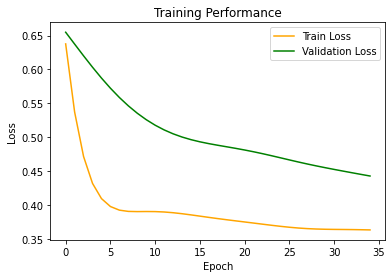

In [18]:
plt.figure()
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(EPOCHS)], losses['train'], color='orange', label='Train Loss')
plt.plot([i for i in range(EPOCHS)], losses['val'], color='green', label='Validation Loss')
plt.legend(loc="upper right")
plt.show()

## 2.4. Save the trained head

The head is save in the same directory as the fine-tuned model. 

In [19]:
torch.save(head.state_dict(), os.path.join(model_path, 'scores_head.pt'))